# Forecasting International Stock Indices

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

In the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01E_Forecasting_US_Stock_Indices.ipynb) we used a mathematical model to forecast the returns of U.S. stock indices such as the S&P 500 and NASDAQ 100. The forecasting model has been tested on a large number of international stock indices. It worked well for some indices and not for others. In this paper, we will use the forecasting model on these international stock indices: Europe (developed markets), Germany, Austria, Emerging Markets, and China.

The forecasting model was presented in [another previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) and requires historical financial data for the dividend yield, sales per share growth, and P/Sales ratios. The fundamental financial data is very expensive to obtain for international stock indices.

The financial data company Morningstar has generously donated historical P/Sales ratios for many international Exchange Traded Funds (ETF) which track international stock indices. The P/Sales ratios were then converted to Sales Per Share data for five ETFs that track the stock indices listed above.

This builds directly on the previous papers, which you are assumed to be familiar with.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.6 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_rel, ttest_ind
import pandas as pd
import numpy as np
import os

In [3]:
# Imports from FinanceOps.
from data_keys import *
from data import load_index_data, load_stock_data
from returns import reinvestment_growth, prepare_ann_returns, prepare_mean_ann_returns

## Load Data

We now load the financial data for the S&P indices.

In [4]:
# Define the ticker-names for the stock-indices we consider.
ticker_SP500 = "S&P 500"
ticker_SP400 = "S&P 400"
ticker_SP600 = "S&P 600"

In [5]:
# Load the financial data for the stock-indices.
df_SP500 = load_index_data(ticker=ticker_SP500)
df_SP400 = load_index_data(ticker=ticker_SP400, book_value=False)
df_SP600 = load_index_data(ticker=ticker_SP600, book_value=False)

### Load Data for ETFs

For NASDAQ 100 and the international stock indices we will use data for Exchange Traded Funds (ETF) that track those indices, which was obtained from the Morningstar Direct database. We need the Sales Per Share data but the database only contains the P/Sales data, so the Sales Per Share has been estimated using this formula:

$$
    Sales\ Per\ Share_t = \frac{Share\ Price_t}{P/Sales_t}
$$

In [6]:
# Tickers for ETFs.
ticker_QQQ = "QQQ"
ticker_VGK = "VGK"
ticker_EWG = "EWG"
ticker_EWO = "EWO"
ticker_EEM = "EEM"
ticker_GXC = "GXC"

# Names and tickers for ETFs.
ticker_name_QQQ = "NASDAQ-100 (QQQ)"
ticker_name_VGK = "Europe Dev. (VGK)"
ticker_name_EWG = "Germany (EWG)"
ticker_name_EWO = "Austria (EWO)"
ticker_name_EEM = "Emerging Markets (EEM)"
ticker_name_GXC = "China (GXC)"

# Load financial data for ETFs.
df_QQQ = load_stock_data(ticker=ticker_QQQ, earnings=False, book_value=False)
df_VGK = load_stock_data(ticker=ticker_VGK, earnings=False, book_value=False)
df_EWG = load_stock_data(ticker=ticker_EWG, earnings=False, book_value=False)
df_EWO = load_stock_data(ticker=ticker_EWO, earnings=False, book_value=False)
df_EEM = load_stock_data(ticker=ticker_EEM, earnings=False, book_value=False)
df_GXC = load_stock_data(ticker=ticker_GXC, earnings=False, book_value=False)

# Estimate Dividend Yield from diff. btw. Total Return and Share-Price.
df_QQQ[DIVIDEND_YIELD] = reinvestment_growth(df_QQQ, smooth=True)
df_VGK[DIVIDEND_YIELD] = reinvestment_growth(df_VGK, smooth=True)
df_EWG[DIVIDEND_YIELD] = reinvestment_growth(df_EWG, smooth=True)
df_EWO[DIVIDEND_YIELD] = reinvestment_growth(df_EWO, smooth=True)
df_EEM[DIVIDEND_YIELD] = reinvestment_growth(df_EEM, smooth=True)
df_GXC[DIVIDEND_YIELD] = reinvestment_growth(df_GXC, smooth=True)

## Mathematical Model

Let us define the Total Return of a stock at time-step $t$ as the number of shares which may grow from reinvestment of dividends (taxes are ignored), multiplied by the share-price:

$$
Total\ Return_t = Shares_t \cdot Share\ Price_t
$$

The annualized return between the start-date $t$ and the end-date $t+Years$ is defined as:

$$
Ann\ Return_t
= \left( \frac{Total\ Return_{t+Years}}{Total\ Return_t} \right) ^ {1/Years} - 1
$$

From this definition, the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) derived two formulas for the mean and standard deviation of the annualized return given the P/Sales ratio at time-step $t$:

$$
E[Ann\ Return_t] = \frac{a}{P/Sales_t ^ {1/Years}} - 1
$$

$$
Std[Ann\ Return_t] = \frac{b}{P/Sales_t ^ {1/Years}}
$$

where the parameters $a$ and $b$ can be estimated from three factors: (1) The growth in the number of shares from reinvestment of dividends, (2) the growth in Sales Per Share, and (3) the change in the P/Sales valuation ratio. The parameters are estimated as:

$$
a \simeq E[Dividend\ Yield + 1]
\cdot E[Sales\ Per\ Share\ Growth + 1]
\cdot E[ P/Sales ^ {1/Years} ]
$$

$$
b \simeq Std \left[ (Dividend\ Yield + 1) \cdot (Sales\ Per\ Share\ Growth + 1) \cdot P/Sales ^ {1/Years} \right]
$$

Forecasting the future return on a stock can therefore be split into forecasting these three factors. We can use historical values for the dividend yield, sales growth, and P/Sales ratios, or we can use other numbers if we think the future will be different from the past.

## Implementation

This class implements the forecasting model.

In [7]:
class ForecastModel:
    """
    Mathematical model used to forecast long-term stock returns.
    """

    def __init__(self, dividend_yield, sales_growth,
                 psales, years):
        """
        Create a new model and fit it with the given data.
        
        :param dividend_yield: Array with dividend yields.
        :param sales_growth: Array with one-year sales growth.
        :param psales: Array with P/Sales ratios.
        :param years: Number of years.
        """
        
        # Copy args to self.
        # Note the +1 for dividend yield and sales-growth
        # so we don't have to do it several times below.
        self.dividend_yield = np.array(dividend_yield) + 1
        self.sales_growth = np.array(sales_growth) + 1
        self.psales = psales
        self.years = years
        
        # Calculate the `a` parameter for the mean ann.return.
        self.a = self.mean_parameter()

        # Calculate the `b` parameter for the std.dev. ann.return.
        self.b = self.std_parameter()

    def forecast(self, psales_t):
        """
        Use the fitted model to forecast the mean and std.dev.
        for the future stock returns.
        
        :param psales_t: Array with different P/Sales ratios at buy-time.
        :return: Two arrays with mean and std.ann. for the ann. returns
                 for each of the psales_t values.
        """

        # Annualized psales_t which is used in both formulas.
        psales_t_ann = psales_t ** (1/self.years)

        # Forecast the mean and std.dev. for the ann. returns
        # for the different choices of P/Sales ratios at the
        # time of buying the stock.
        mean = self.a / psales_t_ann - 1.0
        std = self.b / psales_t_ann

        return mean, std

    def mean_parameter(self):
        """
        Estimate the parameter `a` used in the formula for the
        mean annualized return, given arrays with distributions
        for the dividend yield, sales-growth and P/Sales.

        :return: The parameter `a` for the mean return formula.
        """

        # We assume dividend_yield and sales_growth is already +1.
        a = np.mean(self.dividend_yield) \
          * np.mean(self.sales_growth) \
          * np.mean(self.psales ** (1/self.years))

        return a

    def std_parameter(self, num_samples=10000):
        """
        Estimate the parameter `b` used in the formula for the
        std.dev. annualized return, given arrays with distributions
        for the dividend yield, sales-growth and P/Sales.

        This is estimated using Monte Carlo simulation / resampling
        of the given data, which is assumed to be independent of
        each other and over time.

        :param num_samples: Number of Monte Carlo samples.
        :return: The parameter `b` for the std.dev. return formula.
        """

        # We will do a Monte Carlo simulation / resampling
        # from the supplied arrays of data. For each year
        # we take e.g. 10k random samples and then we
        # calculate the annualized growth-rates. This gives
        # us different values for dividend yields and sales-growth
        # for each year, instead of just taking one random
        # number and using that for all the years.

        # Shape of arrays to sample.
        shape = (num_samples, self.years)
        num_samples_total = np.prod(shape)

        # Sample the dividend yield. We assume it is already +1.
        dividend_yield_sample = np.random.choice(self.dividend_yield, size=shape)
        # Compound the growth through the years.
        dividend_yield_sample = np.prod(dividend_yield_sample, axis=1)

        # Sample the sales-growth. We assume it is already +1.
        sales_growth_sample = np.random.choice(self.sales_growth, size=shape)
        # Compound the growth through the years.
        sales_growth_sample = np.prod(sales_growth_sample, axis=1)

        # Sample the P/Sales ratio at the time of selling.
        psales_sample = np.random.choice(self.psales, size=num_samples)

        # Combine the three samples.
        combined_sample = dividend_yield_sample * sales_growth_sample * psales_sample

        # Calculate the `b` parameter.
        b = np.std(combined_sample ** (1/self.years))

        return b
    
    def _ttest(self, err_forecast, err_baseline):
        """
        Perform a t-test on the residual errors of the
        forecasting model and the baseline to assess whether
        their means are equal.
        
        When the resulting p_value is close to zero, the means
        are unlikely to be equal.
        
        :param err_forecast:
            Residual errors for the forecasting model.

        :param err_baseline:
            Residual errors for the baseline.

        :return:
            p_value
        """
        
        if True:
            # Paired t-test.
            t_value, p_value = ttest_rel(a=err_forecast, b=err_baseline)
        else:
            # Un-paired / independent t-test.
            t_value, p_value = ttest_ind(a=err_forecast, b=err_baseline, equal_var=False)

        return p_value

    def MAE(self, psales_t, ann_rets):
        """
        Calculates the Mean Absolute Error (MAE) between the
        model's forecasted mean and the observed annualized returns.
        
        Also calculates the MAE between the baseline and the
        observed annualized returns.
        
        Also calculates the p-value that the forecasted and
        baseline MAE values are equal.
        
        :param psales_t:
            Array with different P/Sales ratios at buy-time.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            mae_forecast: MAE between model's forecast and actual returns.
            mae_baseline: MAE between baseline and actual returns.
            p_value: p-value whether the two MAE values are equal.
        """

        # Forecast the mean and std.dev. for the stock returns,
        # from the historical P/Sales ratios.
        mean_forecast, std_forecast = self.forecast(psales_t=psales_t)

        # Errors between observed data and forecasting model.
        err_forecast = np.abs(ann_rets - mean_forecast)
        
        # Baseline errors between observed data and its mean.
        err_baseline = np.abs(ann_rets - np.mean(ann_rets))
        
        # Mean Absolute Errors (MAE).
        mae_forecast = np.mean(err_forecast)
        mae_baseline = np.mean(err_baseline)
        
        # Hypothesis test whether the two MAE values are equal.
        p_value = self._ttest(err_forecast=err_forecast,
                              err_baseline=err_baseline)

        return mae_forecast, mae_baseline, p_value
    
    def R_squared(self, psales_t, ann_rets):
        """
        Calculate the Coefficient of Determination R^2 for
        measuring the Goodness of Fit between the forecasted
        mean and the observed annualized returns.

        An R^2 value of one means there is a perfect fit and
        the forecasting model explains all of the variance
        in the data. An R^2 value of zero means the forecasting
        model does not explain any of the variance in the data.
        
        Note that because the forecasting model is non-linear,
        the R^2 can become negative if the model fits poorly
        on data with a large variance.

        :param psales_t:
            Array with different P/Sales ratios at buy-time.
            
        :param ann_rets:
            Array with the corresponding annualized returns.

        :return:
            R^2 value.
        """

        # Forecast the mean and std.dev. for the stock returns,
        # from the historical P/Sales ratios.
        mean_forecast, std_forecast = self.forecast(psales_t=psales_t)

        # Errors between observed data and forecasting model.
        err_forecast = (ann_rets - mean_forecast) ** 2
        
        # Baseline errors between observed data and its mean.
        err_baseline = (ann_rets - np.mean(ann_rets)) ** 2
        
        # Sum of Squared Errors (SSE) for the forecasting model.
        sse = np.sum(err_forecast)
        
        # Sum of Squared Errors (SST) for the baseline.
        sst = np.sum(err_baseline)

        # The R^2 value.
        R_squared = 1.0 - sse / sst
        
        return R_squared

## Print Statistics

This helper-function prints the various statistics for a forecasting model.

In [8]:
def print_statistics(model, psales_t, ann_rets):
    """
    Calculate and print the Goodness of Fit statistics
    for a model's forecast compared to the baseline.

    The p-value results from a paired t-test whether
    the values are equal. A p-value close to zero means
    that the values are unlikely to be equal.

    :param model:
        Instance of the ForecastModel class.

    :param psales_t:
        Array with different P/Sales ratios at buy-time.

    :param ann_rets:
        Array with the corresponding annualized returns.
    """
    
    # Print header.
    print("\tForecast\tBaseline\tp-value")
    print("=================================================")

    # Mean Absolute Error (MAE).
    mae_forecast, mae_baseline, p_value = model.MAE(psales_t=psales_t,
                                                    ann_rets=ann_rets)
    msg = "MAE:\t{0:.1%}\t\t{1:.1%}\t\t{2:.2e}"
    msg = msg.format(mae_forecast, mae_baseline, p_value)
    print(msg)

    # R^2.
    R_squared = model.R_squared(psales_t=psales_t,
                                ann_rets=ann_rets)
    msg = "R^2:\t{0:.2f}"
    msg = msg.format(R_squared)
    print(msg)

## Plotting Functions

This is the helper-function for plotting the historical annualized returns and overlay them with the mean and standard deviation of the forecasting model.

In [9]:
def plot_ann_returns(ticker, df, years, years_range=0,
                     dividend_yield=None, sales_growth=None,
                     psales=None,
                     psales_min=None, psales_max=None):
    """
    Create a plot with the actual historical returns showing
    the P/Sales ratios vs. future Annualized Returns. Overlay
    this plot with the estimated mean and std.dev. from the
    mathematical forecasting model we have derived above.
    
    The optional params are taken from the DataFrame `df`
    if not supplied. This allows you to override some or
    all of the data used in the forecasting model e.g.
    to change assumptions about future sales-growth.
    
    :param ticker: String with ticker for the stock or index.
    :param df: Pandas DataFrame.
    :param years: Number of investment years.
    :param years_range:
        If > 0 then plot the mean ann. returns between
        years - years_range and years + years_range.
    :param dividend_yield: (Optional) Array with dividend yields.
    :param sales_growth: (Optional) Array with one-year sales growth.
    :param psales: (Optional) Array with P/Sales ratios.
    :param psales_min: (Optional) Min P/Sales for plotting curves.
    :param psales_max: (Optional) Max P/Sales for plotting curves.
    :return: None.
    """
    
    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Select only the data we need.
    df2 = df[[TOTAL_RETURN, DIVIDEND_YIELD, SALES_GROWTH, PSALES]]

    # Remove rows for which there is missing data.
    df2 = df2.dropna()
    
    # Part of the title for the data's date-range.
    start_date, end_date = df2.index[[0, -1]]
    title_dates = "({0}-{1})".format(start_date.year, end_date.year)

    # Get Dividend Yield if none provided.
    if dividend_yield is None:
        dividend_yield = df2[DIVIDEND_YIELD]

    # Get Sales Growth if none provided.
    if sales_growth is None:
        sales_growth = df2[SALES_GROWTH]

    # Get P/Sales if none provided.
    if psales is None:
        psales = df2[PSALES]

    # Get min P/Sales for plotting if none provided.
    if psales_min is None:
        psales_min = np.min(psales)
    
    # Get max P/Sales for plotting if none provided.
    if psales_max is None:
        psales_max = np.max(psales)
        
    # Create the forecasting model and fit it to the data.
    model = ForecastModel(dividend_yield=dividend_yield,
                          sales_growth=sales_growth,
                          psales=psales, years=years)
    
    # Evenly spaced P/Sales ratios between historic min and max.
    psales_t = np.linspace(start=psales_min, stop=psales_max, num=100)

    # Use the model to forecast the mean and std ann.returns.
    mean, std = model.forecast(psales_t=psales_t)

    # Plot the mean ann.return.
    ax.plot(psales_t, mean, color="black", label="Forecast Mean")
    
    # Plot one standard deviation.
    color = "green"
    alpha = 0.3
    # Plot lines below and above mean.
    ax.plot(psales_t, mean-std, color=color,
            label="Forecast Mean $\pm$ 1 Std.Dev.")
    ax.plot(psales_t, mean+std, color=color)
    # Fill the areas.
    ax.fill_between(psales_t, mean+std, mean-std,
                    color=color, edgecolor=color, alpha=alpha)
    
    # Plot two standard deviations.
    color = "red"
    alpha = 0.1
    # Plot lines below and above mean.
    ax.plot(psales_t, mean-2*std, color=color,
            label="Forecast Mean $\pm$ 2 Std.Dev.")
    ax.plot(psales_t, mean+2*std, color=color) 
    # Fill the areas.
    ax.fill_between(psales_t, mean-std, mean-2*std,
                    color=color, edgecolor=color, alpha=alpha)
    ax.fill_between(psales_t, mean+std, mean+2*std,
                    color=color, edgecolor=color, alpha=alpha)

    # Get the actual ann. returns from the historic data.
    if years_range > 0:
        # Use the mean. ann. returns between [min_years, max_years].
        min_years = years - years_range
        if min_years < 1:
            min_years = 1
        max_years = years + years_range

        # Get the mean ann.returns from the historic data.
        x, y = prepare_mean_ann_returns(df=df2,
                                        min_years=min_years,
                                        max_years=max_years,
                                        key=PSALES)

        # First part of the plot-title.
        title1 = "[{0}] {1}-{2} Year Mean Ann. Return {3}".format(ticker, min_years, max_years, title_dates)
        
        # Label for the scatter-plot of actual returns.
        label_returns = "Actual Returns (Mean)"
    else:
        # Get the ann.returns from the historic data.
        x, y = prepare_ann_returns(df=df2, years=years, key=PSALES)
    
        # First part of the plot-title.
        title1 = "[{0}] {1}-Year Ann. Return {2}".format(ticker, years, title_dates)
        
        # Label for the scatter-plot of actual returns.
        label_returns = "Actual Returns"

    # Scatter-plot with the actual P/Sales vs. Ann.Returns.
    ax.scatter(x, y, label=label_returns)

    # Plot baseline mean as horizontal dashed line.
    ax.axhline(y=np.mean(y), color="black", linestyle="--",
               label="Baseline")

    # Show the labels for what we have just plotted.
    ax.legend()

    # Create plot-title.
    # Second part of the title. Formula for mean ann. return.
    msg = "E[Ann Return] = {0:.2f} / (P/Sales ^ (1/{1})) - 1"
    title2 = msg.format(model.a, years)
    # Third part of the title. Formula for std.dev. ann. return.
    msg = "Std[Ann Return] = {0:.3f} / (P/Sales ^ (1/{1}))"
    title3 = msg.format(model.b, years)
    # Combine and set the plot-title.
    title = "\n".join([title1, title2, title3])
    ax.set_title(title)

    # Convert y-ticks to percentages.
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
    ax.yaxis.set_major_formatter(formatter)

    # Set axes labels.
    ax.set_xlabel("P/Sales")
    ax.set_ylabel("Annualized Return")

    # Show grid.
    ax.grid()
    
    # Show the plot.
    plt.show()
    
    # Print the Goodness of Fit statistics.
    print_statistics(model=model, psales_t=x, ann_rets=y)

This is a helper-function to plot a comparison of the Share-Price and Total Return.

In [10]:
def plot_price_total_return(df):
    """
    Plot Share-Price and Total Return normalized to start at 1.
    """
    
    df2 = df[[TOTAL_RETURN, SHARE_PRICE]].dropna()
    df2 /= df2.values[0]
    df2.plot(grid=True)

## Europe Developed (VGK)

The ETF with ticker symbol VGK tracks the FTSE Developed Europe All Cap Index (see [description](https://investor.vanguard.com/etf/profile/VGK)). It contains more than 1300 stocks with low annual turnover (see [Morningstar](http://portfolios.morningstar.com/fund/holdings?t=VGK&region=usa&culture=en-US)).

### Europe (VGK) - Price and Total Return

The following plot compares the share-price of VGK with its Total Return between 2005 and 2019. The Total Return is calculated by reinvesting the dividends back into the ETF stocks while ignoring taxes.

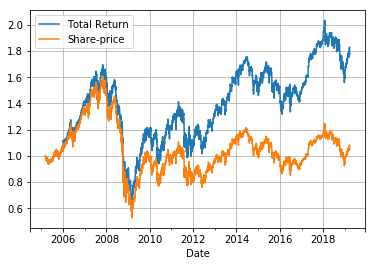

In [11]:
plot_price_total_return(df=df_VGK)

### Europe (VGK)  - P/Sales

The following plot and statistics show that the P/Sales ratio varied roughly between 0.5 and 1.4 between 2005 and 2019, with a mean around 1.0.

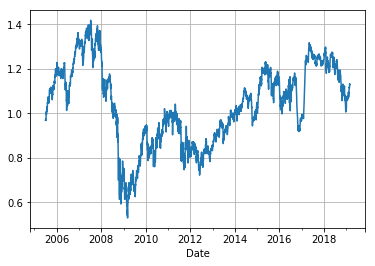

In [12]:
df_VGK[PSALES].plot(grid=True)

In [13]:
df_VGK[PSALES].describe()

count    4992.000000
mean        1.037513
std         0.180692
min         0.530109
25%         0.905443
50%         1.048679
75%         1.182313
max         1.418060
Name: P/Sales, dtype: float64

### Europe (VGK)  - Sales Growth

An important factor of the forecasting model is the growth in sales per share. The following plot and statistics show that VGK has had volatile but apparently also mean-reverting sales growth between 2005 and 2019, with the mean being around 0.0% and the extremes being -22% and 18%.

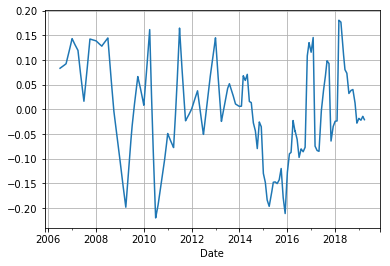

In [14]:
df_VGK[SALES_GROWTH].plot(grid=True)

In [15]:
df_VGK[SALES_GROWTH].describe()

count    4652.000000
mean        0.003005
std         0.095244
min        -0.220111
25%        -0.062065
50%         0.010607
75%         0.078717
max         0.180344
Name: Sales Growth, dtype: float64

### Europe (VGK)  - Dividend Yield

The following plot and statistics show the historical dividend yield for VGK between 2005 and 2019. The dividend yield ranged between 1.4% and 11% with a mean about 4.0%.

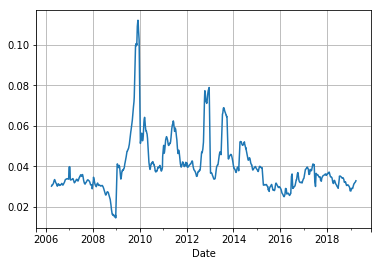

In [16]:
df_VGK[DIVIDEND_YIELD].plot(grid=True)

In [17]:
df_VGK[DIVIDEND_YIELD].describe()

count    4745.000000
mean        0.039791
std         0.013455
min         0.014457
25%         0.031462
50%         0.036294
75%         0.042552
max         0.112254
Name: Dividend Yield, dtype: float64

### Europe (VGK)  - 1 Year Returns

We now use the forecasting model on the historical data between 2005 and 2019. The plot shows the actual one-year returns of VGK as blue dots. The forecasted mean return is the black solid line. The green area is one forecasted standard deviation around the mean, and the red area is two standard deviations. The dashed black line is the baseline used for comparison and it is just the mean annualized return for the historical data.

The forecasting model fits the model slightly better than the baseline with $R^2 = 0.08$.

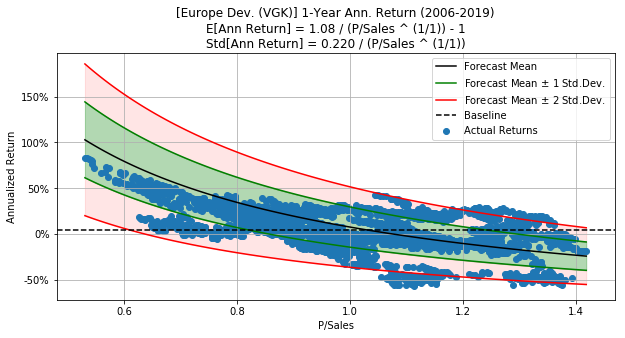

	Forecast	Baseline	p-value
MAE:	16.3%		16.7%		7.16e-02
R^2:	0.08


In [18]:
plot_ann_returns(years=1, ticker=ticker_name_VGK, df=df_VGK)

### Europe (VGK) - 2 Year Returns

Already for 2-year periods, the forecasting model starts to fit the historical returns fairly well with $R^2 = 0.48$.

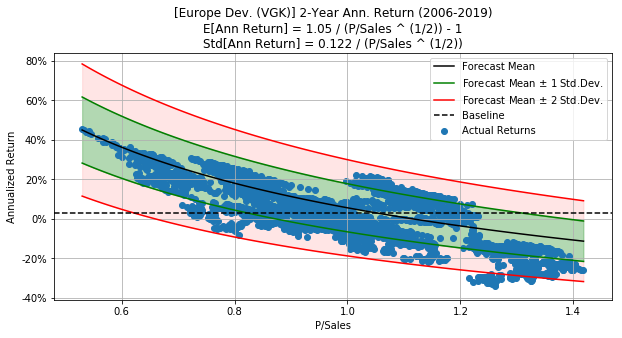

	Forecast	Baseline	p-value
MAE:	8.3%		10.7%		7.53e-63
R^2:	0.48


In [19]:
plot_ann_returns(years=2, ticker=ticker_name_VGK, df=df_VGK)

### Europe (VGK) - 5 Year Returns

For 5-year periods, the forecasting model fits the historical data very well with $R^2 = 0.79$.

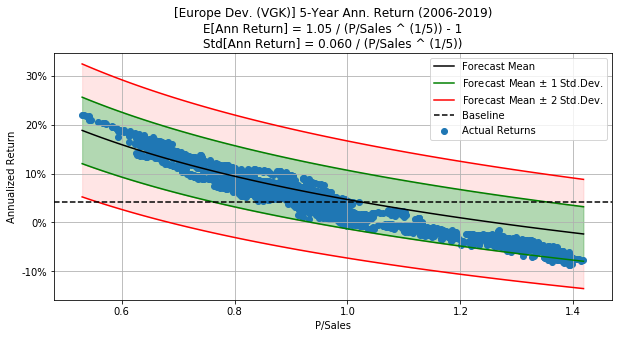

	Forecast	Baseline	p-value
MAE:	2.3%		4.9%		1.24e-316
R^2:	0.79


In [20]:
plot_ann_returns(years=5, ticker=ticker_name_VGK, df=df_VGK)

### Europe (VGK) - 10 Year Returns

For 10-year returns, the forecasting model fits the historical returns very well with $R^2 = 0.86$. However, the data covers the period between 2005 and 2019, which means that the start-dates only range between 2005 and 2009, so it is actually a fairly short period that is covered.

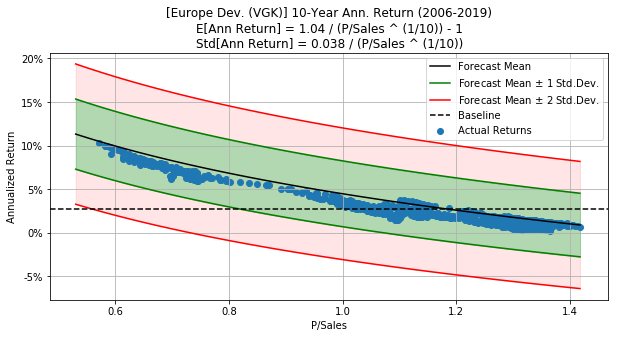

	Forecast	Baseline	p-value
MAE:	0.7%		1.7%		1.18e-76
R^2:	0.86


In [21]:
plot_ann_returns(years=10, ticker=ticker_name_VGK, df=df_VGK)

### Europe (VGK) - 3 to 7 Year Returns

This plot shows the historical returns averaged for 3-7 year investment periods, which will be used for comparison to the other stock indices. The forecasting model has a very good fit to the historical data with $R^2 = 0.82$.

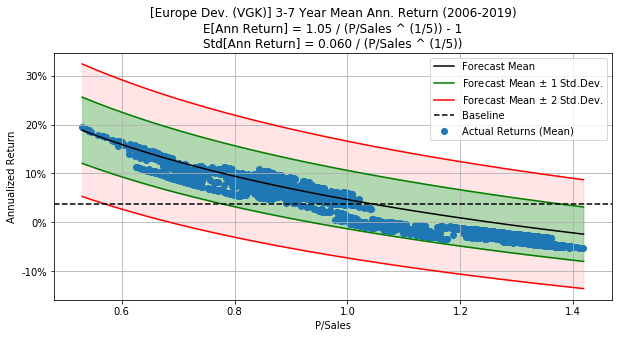

	Forecast	Baseline	p-value
MAE:	2.0%		5.0%		0.00e+00
R^2:	0.82


In [22]:
plot_ann_returns(years=5, years_range=2,
                 ticker=ticker_name_VGK, df=df_VGK)

## Germany (EWG)

The ETF with ticker symbol EWG tracks the MSCI Germany Index (see [description](https://www.ishares.com/us/products/239650/ishares-msci-germany-etf)). It currently contains 65 stocks with low turnover (see [Morningstar](http://portfolios.morningstar.com/fund/holdings?t=EWG&region=usa&culture=en-US)).

### Germany (EWG) - Price and Total Return

The following plot compares the share-price with the Total Return between 2002 and 2019. The Total Return is calculated by reinvesting the dividends back into the ETF stocks while ignoring taxes.

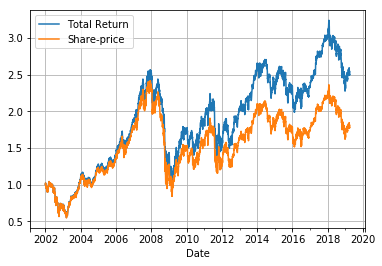

In [23]:
plot_price_total_return(df=df_EWG["2002":])

### Germany (EWG)  - P/Sales

The following plot and statistics show that the P/Sales ratio varied roughly between 0.3 and 1.1 between 2002 and 2019, with a mean around 0.7.

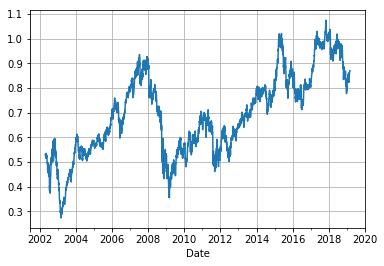

In [24]:
df_EWG[PSALES].plot(grid=True)

In [25]:
df_EWG[PSALES].describe()

count    6149.000000
mean        0.691832
std         0.168114
min         0.273001
25%         0.558153
50%         0.681771
75%         0.810647
max         1.074430
Name: P/Sales, dtype: float64

### Germany (EWG) - Sales Growth

This plot shows the growth in sales per share between 2002 and 2019. Apart from the strange spike around year 2004, the sales growth seems to be mean reverting with an average around 2.3%.

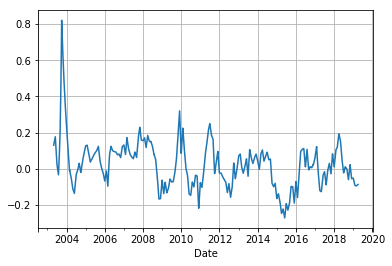

In [26]:
df_EWG[SALES_GROWTH].plot(grid=True)

In [27]:
df_EWG[SALES_GROWTH].describe()

count    5816.000000
mean        0.022957
std         0.126451
min        -0.272012
25%        -0.064444
50%         0.022950
75%         0.092796
max         0.821297
Name: Sales Growth, dtype: float64

### Germany (EWG)  - Dividend Yield

The following plot and statistics show the historical dividend yield between 2002 and 2019, which ranged between 0% and 5% with a mean around 2%.

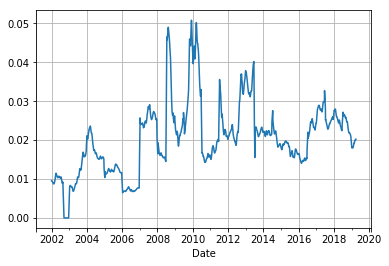

In [28]:
df_EWG[DIVIDEND_YIELD]["2002":].plot(grid=True)

In [29]:
df_EWG[DIVIDEND_YIELD]["2002":].describe()

count    6.300000e+03
mean     2.056080e-02
std      9.219166e-03
min     -9.659512e-08
25%      1.517134e-02
50%      2.072479e-02
75%      2.508155e-02
max      5.080119e-02
Name: Dividend Yield, dtype: float64

### Germany (EWG) - 1 Year Returns

We now use the forecasting model on the historical data between 2002 and 2019. For 1-year returns the forecasting model fits the data very poorly with $R^2 = -0.25$.

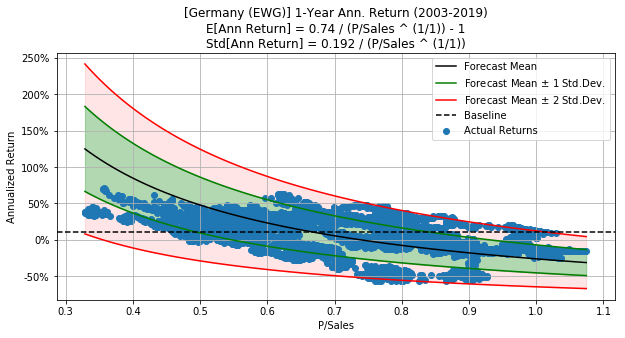

	Forecast	Baseline	p-value
MAE:	20.8%		18.4%		3.60e-25
R^2:	-0.25


In [30]:
plot_ann_returns(years=1, ticker=ticker_name_EWG, df=df_EWG)

### Germany (EWG) - 2 Year Returns

Already for 2-year investment periods, the forecasting model starts to fit the historical returns reasonably well for such short periods, with $R^2 = 0.39$.

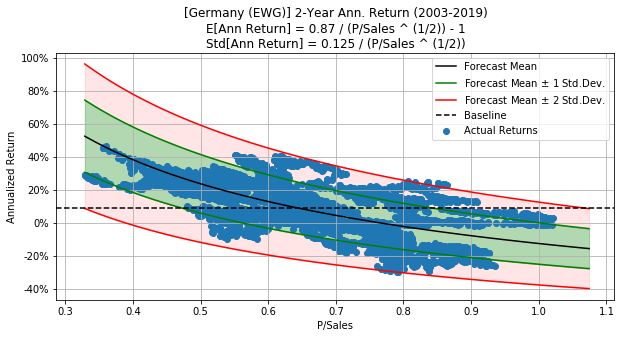

	Forecast	Baseline	p-value
MAE:	10.3%		13.2%		2.95e-125
R^2:	0.39


In [31]:
plot_ann_returns(years=2, ticker=ticker_name_EWG, df=df_EWG)

### Germany (EWG) - 5 Year Returns

For 5-year periods, the forecasting model also fits the historical returns reasonably well with $R^2 = 0.68$.

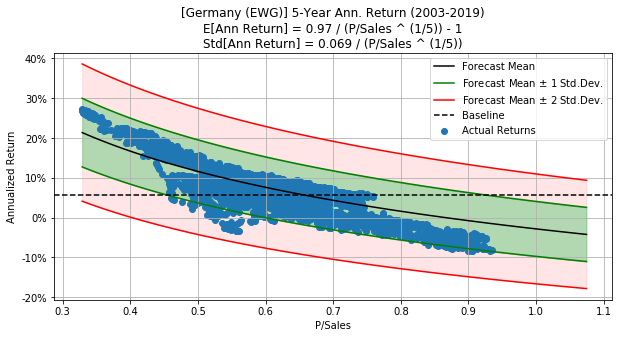

	Forecast	Baseline	p-value
MAE:	3.0%		4.8%		4.72e-182
R^2:	0.68


In [32]:
plot_ann_returns(years=5, ticker=ticker_name_EWG, df=df_EWG)

### Germany (EWG) - 10 Year Returns

This plot shows the historical 10-year returns, which has a very good fit with $R^2 = 0.84$. However, the data covers the period between 2003 and 2019, which means that the start-dates only range between 2003 and 2009, so it is actually a fairly short period that is covered.

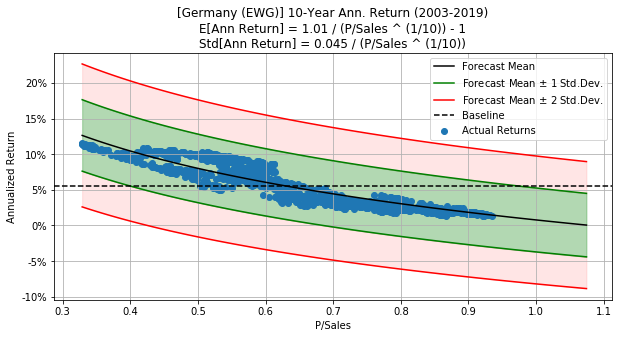

	Forecast	Baseline	p-value
MAE:	1.0%		2.7%		0.00e+00
R^2:	0.84


In [33]:
plot_ann_returns(years=10, ticker=ticker_name_EWG, df=df_EWG)

### Germany (EWG) - 3 to 7 Year Returns

This plot shows the historical returns averaged for 3-7 year investment periods, which will be used for comparison to the other stock indices. The forecasting model has a very good fit to the historical data with $R^2 = 0.82$.

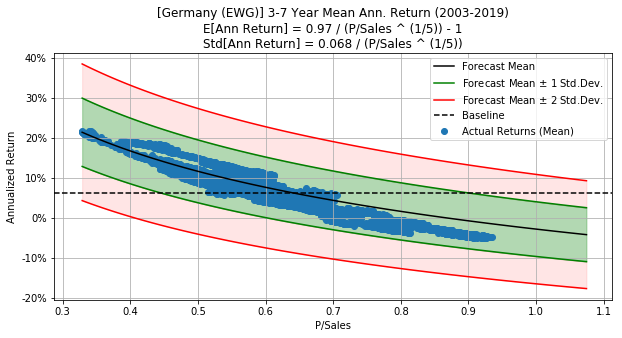

	Forecast	Baseline	p-value
MAE:	2.2%		5.0%		0.00e+00
R^2:	0.82


In [34]:
plot_ann_returns(years=5, years_range=2,
                 ticker=ticker_name_EWG, df=df_EWG)

## Austria (EWO)

The ETF with ticker symbol EWO tracks the MSCI Austria Index (see [description](https://www.ishares.com/us/products/239609/ishares-msci-austria-capped-etf)). It currently contains 27 stocks with moderate annual turnover (see [Morningstar](http://portfolios.morningstar.com/fund/holdings?t=EWO&region=usa&culture=en-US)).

### Austria (EWO) - Price and Total Return

The following plot compares the share-price with the Total Return between 2002 and 2019. The Total Return is calculated by reinvesting the dividends back into the ETF stocks while ignoring taxes.

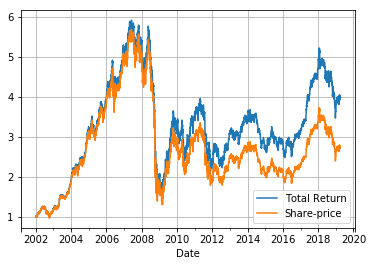

In [35]:
plot_price_total_return(df=df_EWO["2002":])

### Austria (EWO)  - P/Sales

The following plot and statistics show that the P/Sales ratio varied roughly between 0.3 and 2.0 between 2002 and 2019, with a mean around 0.9.

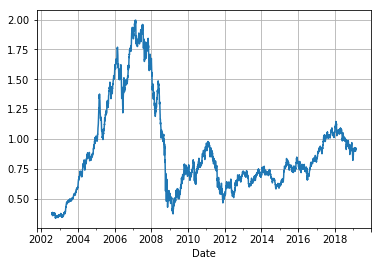

In [36]:
df_EWO[PSALES].plot(grid=True)

In [37]:
df_EWO[PSALES].describe()

count    6057.000000
mean        0.897275
std         0.381693
min         0.337430
25%         0.649614
50%         0.776908
75%         1.032318
max         1.995375
Name: P/Sales, dtype: float64

### Austria (EWO) - Sales Growth

This plot shows the growth in sales per share between 2002 and 2019, which seems to be mean reverting with an average around 0.8%.

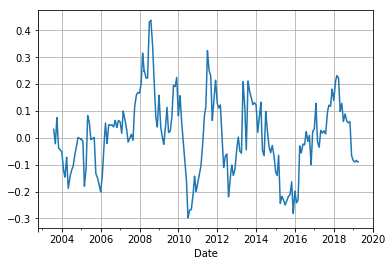

In [38]:
df_EWO[SALES_GROWTH].plot(grid=True)

In [39]:
df_EWO[SALES_GROWTH].describe()

count    5724.000000
mean        0.008311
std         0.136985
min        -0.298263
25%        -0.085925
50%         0.008858
75%         0.095979
max         0.437689
Name: Sales Growth, dtype: float64

### Austria (EWO)  - Dividend Yield

The following plot and statistics show the historical dividend yield between 2002 and 2019, which ranged between 0% and 5% with a mean about 2.2%.

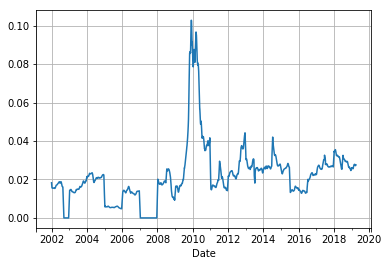

In [40]:
df_EWO[DIVIDEND_YIELD]["2002":].plot(grid=True)

In [41]:
df_EWO[DIVIDEND_YIELD]["2002":].describe()

count    6.300000e+03
mean     2.226467e-02
std      1.564955e-02
min     -2.062639e-07
25%      1.433752e-02
50%      2.090989e-02
75%      2.677035e-02
max      1.028075e-01
Name: Dividend Yield, dtype: float64

### Austria (EWO) - 1 Year Returns

We now use the forecasting model on the historical data between 2002 and 2019. For 1-year returns the forecasting model fits the data very poorly with $R^2 = -0.51$.

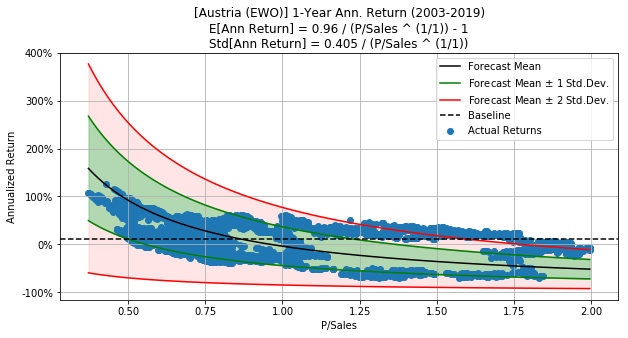

	Forecast	Baseline	p-value
MAE:	35.1%		25.7%		1.08e-115
R^2:	-0.51


In [42]:
plot_ann_returns(years=1, ticker=ticker_name_EWO, df=df_EWO)

### Austria (EWO) - 2 Year Returns

For 2-year investment periods, the forecasting model starts to fit the historical returns although with a quite low $R^2 = 0.19$.

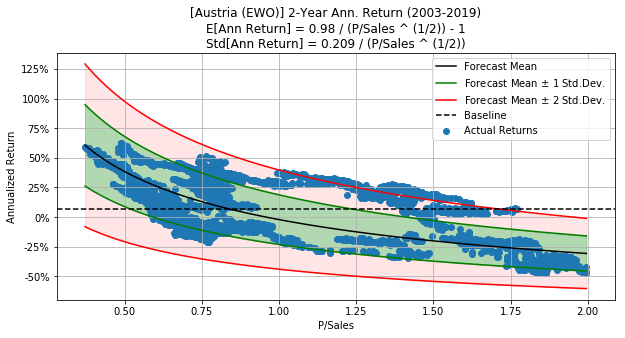

	Forecast	Baseline	p-value
MAE:	18.1%		19.2%		1.14e-06
R^2:	0.19


In [43]:
plot_ann_returns(years=2, ticker=ticker_name_EWO, df=df_EWO)

### Austria (EWO) - 5 Year Returns

For 5 year investment periods, the forecasting model fits the data reasonably well with $R^2 = 0.50$.

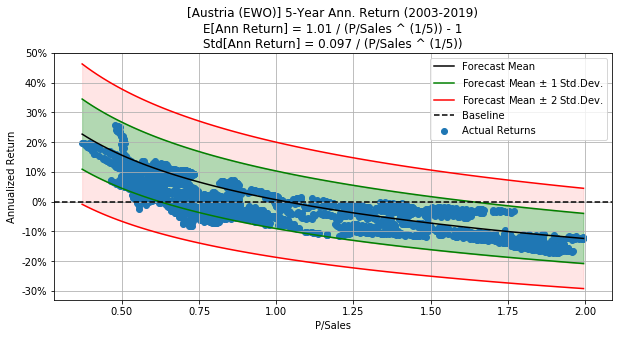

	Forecast	Baseline	p-value
MAE:	4.8%		6.7%		5.21e-64
R^2:	0.50


In [44]:
plot_ann_returns(years=5, ticker=ticker_name_EWO, df=df_EWO)

### Austria (EWO) - 10 Year Returns

For 10 year investment periods, the forecasting model has a very good fit with $R^2 = 0.88$. However, the data covers the period between 2003 and 2019, which means that the start-dates only range between 2003 and 2009, so it is actually a fairly short period that is covered.

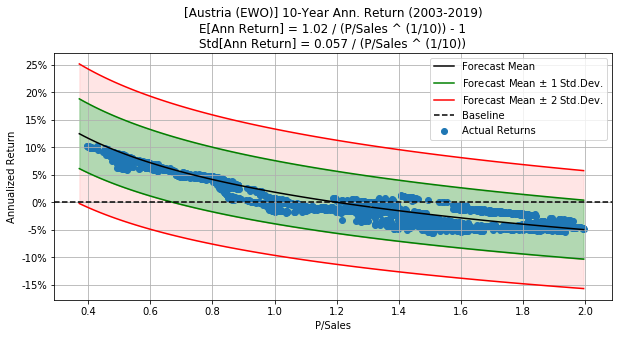

	Forecast	Baseline	p-value
MAE:	1.2%		3.5%		1.14e-243
R^2:	0.88


In [45]:
plot_ann_returns(years=10, ticker=ticker_name_EWO, df=df_EWO)

### Austria (EWO) - 3 to 7 Year Returns

This plot shows the historical returns averaged for 3-7 year investment periods, which will be used for comparison to the other stock indices. The forecasting model has a reasonable fit to the historical data with $R^2 = 0.65$.

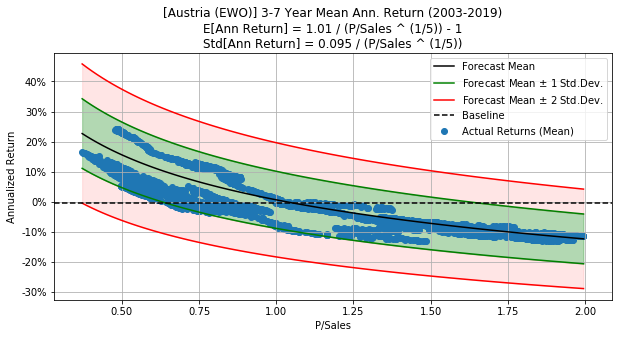

	Forecast	Baseline	p-value
MAE:	4.4%		7.2%		2.53e-135
R^2:	0.65


In [46]:
plot_ann_returns(years=5, years_range=2,
                 ticker=ticker_name_EWO, df=df_EWO)

## Emerging Markets (EEM)

The ETF with ticker symbol EEM tracks the MSCI Emerging Market Index (see [description](https://www.ishares.com/us/products/239637/ishares-msci-emerging-markets-etf)). It currently contains about 950 stocks from Latin America, Emerging Europe, Africa, Middle East, and about 75% from Asia (see [Morningstar](http://portfolios.morningstar.com/fund/holdings?t=EEM&region=usa&culture=en-US) and [here](http://portfolios.morningstar.com/fund/summary?t=EEM&region=usa&culture=en-US)).

### Emerging Markets (EEM) - Price and Total Return

The following plot compares the share-price with the Total Return between 2003 and 2019. The Total Return is calculated by reinvesting the dividends back into the ETF stocks while ignoring taxes.

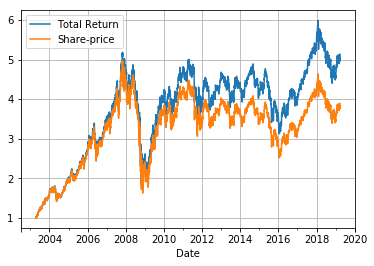

In [47]:
plot_price_total_return(df=df_EEM)

### Emerging Markets (EEM) - P/Sales

The following plot and statistics show that the P/Sales ratio varied roughly between 0.9 and 2.4 between 2003 and 2019, with a mean around 1.3.

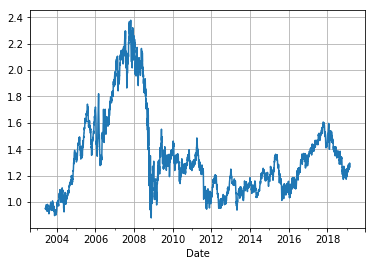

In [48]:
df_EEM[PSALES].plot(grid=True)

In [49]:
df_EEM[PSALES].describe()

count    5753.000000
mean        1.344920
std         0.314131
min         0.879153
25%         1.118562
50%         1.277245
75%         1.456321
max         2.377979
Name: P/Sales, dtype: float64

### Emerging Markets (EEM) - Sales Growth

The following plot and statistics show that the sales growth varied greatly from -27% to 64% between 2004 and 2019, with a mean around 5.7%.

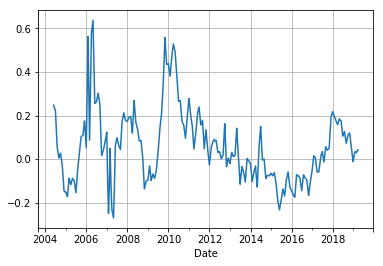

In [50]:
df_EEM[SALES_GROWTH].plot(grid=True)

In [51]:
df_EEM[SALES_GROWTH].describe()

count    5417.000000
mean        0.057250
std         0.163235
min        -0.269769
25%        -0.073286
50%         0.033249
75%         0.157668
max         0.637546
Name: Sales Growth, dtype: float64

### Emerging Markets (EEM) - Dividend Yield

The following plot and statistics show that the dividend yield ranged from 0.6% to 4.3% between 2004 and 2019, with a mean around 1.9%.

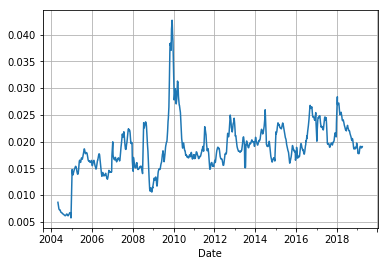

In [52]:
df_EEM[DIVIDEND_YIELD].plot(grid=True)

In [53]:
df_EEM[DIVIDEND_YIELD].describe()

count    5445.000000
mean        0.018774
std         0.004928
min         0.005720
25%         0.016384
50%         0.018570
75%         0.021423
max         0.042673
Name: Dividend Yield, dtype: float64

### Emerging Markets (EEM) - 1 Year Returns

We now use the forecasting model on the historical data between 2003 and 2019. For 1-year returns the forecasting model fits the data very poorly with $R^2 = -0.34$.

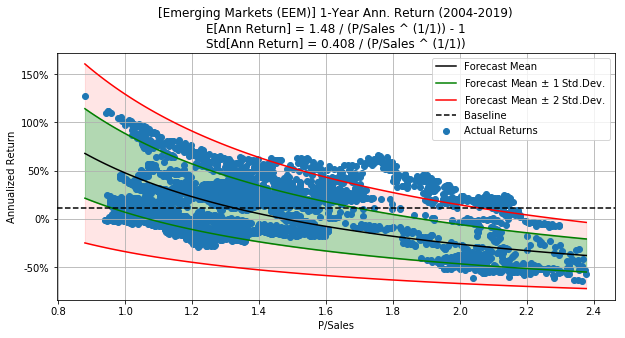

	Forecast	Baseline	p-value
MAE:	26.4%		20.6%		2.86e-94
R^2:	-0.34


In [54]:
plot_ann_returns(years=1, ticker=ticker_name_EEM, df=df_EEM)

### Emerging Markets (EEM) - 2 Year Returns

For 2-year investment periods, the forecasting model also fits the data very poorly with $R^2 = -0.15$.

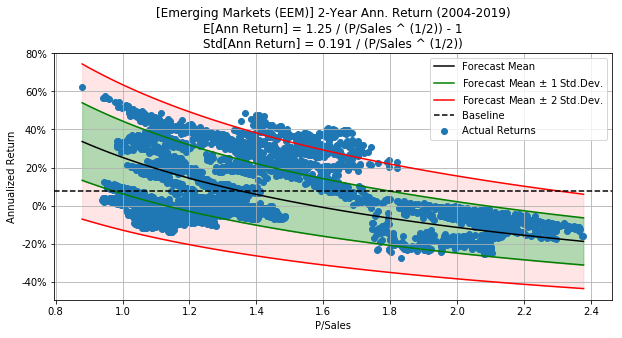

	Forecast	Baseline	p-value
MAE:	15.1%		13.9%		9.37e-20
R^2:	-0.15


In [55]:
plot_ann_returns(years=2, ticker=ticker_name_EEM, df=df_EEM)

### Emerging Markets (EEM) - 5 Year Returns

For 5 year investment periods, there seems to be two trends in the data, but the forecasting model can only estimate one trend, so the overall fit is very poor with $R^2 = -0.57$.

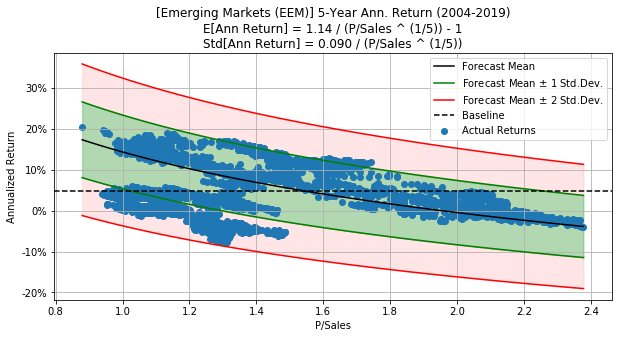

	Forecast	Baseline	p-value
MAE:	6.5%		5.0%		8.09e-60
R^2:	-0.57


In [56]:
plot_ann_returns(years=5, ticker=ticker_name_EEM, df=df_EEM)

### Emerging Markets (EEM) - 10 Year Returns

For 10 year investment periods, the forecasting model has a reasonable fit with $R^2 = 0.53$. However, the data covers the period between 2004 and 2019, which means that the start-dates only range between 2004 and 2009, so it is actually a fairly short period that is covered.

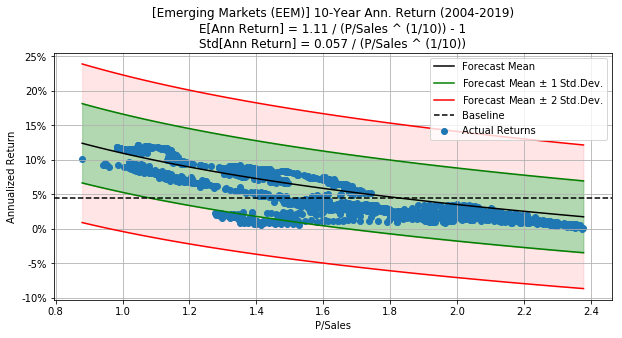

	Forecast	Baseline	p-value
MAE:	1.8%		2.8%		1.74e-72
R^2:	0.53


In [57]:
plot_ann_returns(years=10, ticker=ticker_name_EEM, df=df_EEM)

### Emerging Markets (EEM) - 6 to 10 Year Returns

This plot shows the historical returns averaged for 6-10 year investment periods, which has a good fit with $R^2 = 0.76$. But it should again be noted that the start-dates only cover a fairly short period between 2004 and 2009.

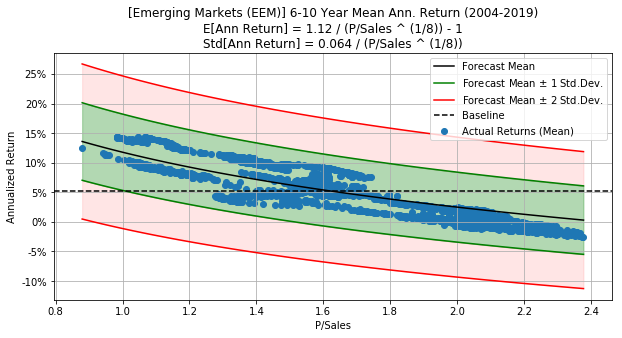

	Forecast	Baseline	p-value
MAE:	1.9%		3.9%		7.52e-274
R^2:	0.76


In [58]:
plot_ann_returns(years=8, years_range=2,
                 ticker=ticker_name_EEM, df=df_EEM)

### Emerging Markets (EEM) - 3 to 7 Year Returns

This plot shows the historical returns averaged for 3-7 year investment periods. There appears to be 2 trends in the data, and because the forecasting model can only estimate a single trend, the overall fit is very poor with $R^2 = -0.03$.

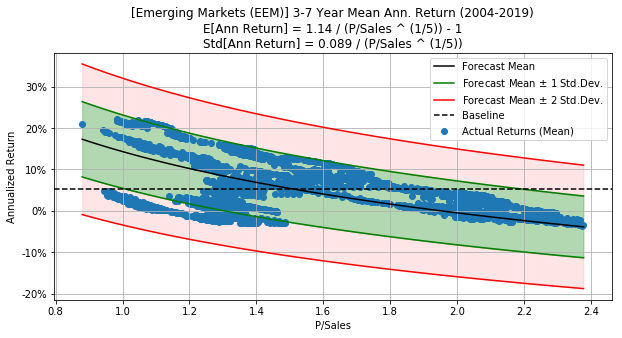

	Forecast	Baseline	p-value
MAE:	5.4%		5.3%		8.85e-02
R^2:	-0.03


In [59]:
plot_ann_returns(years=5, years_range=2,
                 ticker=ticker_name_EEM, df=df_EEM)

## China (GXC)

The ETF with ticker symbol GXC tracks the S&P China Index and contains about 360 stocks with low turnover (see [Morningstar](http://portfolios.morningstar.com/fund/holdings?t=GXC&region=usa&culture=en-US)).

### China (GXC) - Price and Total Return

The following plot compares the share-price with the Total Return between 2007 and 2019. The Total Return is calculated by reinvesting the dividends back into the ETF stocks while ignoring taxes.

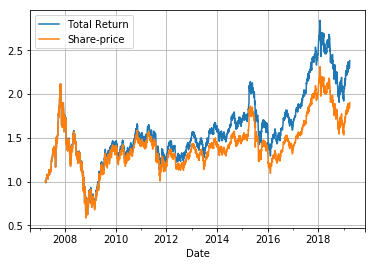

In [60]:
plot_price_total_return(df=df_GXC)

### China (GXC) - P/Sales

The following plot and statistics show that the P/Sales ratio varied roughly between 0.9 and 3.5 between 2007 and 2019, with a mean around 1.5.

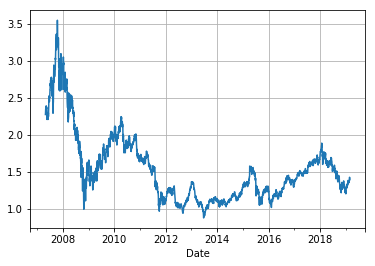

In [61]:
df_GXC[PSALES].plot(grid=True)

In [62]:
df_GXC[PSALES].describe()

count    4323.000000
mean        1.534292
std         0.465735
min         0.878585
25%         1.184175
50%         1.410868
75%         1.717629
max         3.544972
Name: P/Sales, dtype: float64

### China (GXC) - Sales Growth

The following plot and statistics show that the sales growth varied greatly from -14% to 48% between 2008 and 2019, with a mean around 9.0%.

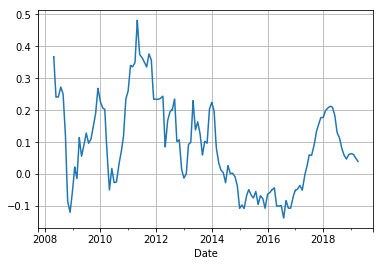

In [63]:
df_GXC[SALES_GROWTH].plot(grid=True)

In [64]:
df_GXC[SALES_GROWTH].describe()

count    3990.000000
mean        0.089605
std         0.135770
min        -0.137144
25%        -0.025492
50%         0.077904
75%         0.198219
max         0.481726
Name: Sales Growth, dtype: float64

### China (GXC) - Dividend Yield

The following plot and statistics show that the dividend yield varied from almost 0% to 5.1% between 2008 and 2019, with a mean around 2.1%.

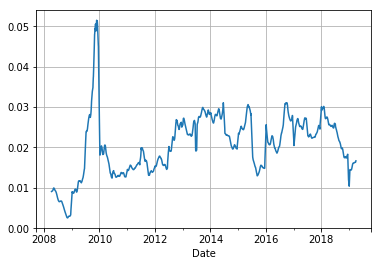

In [65]:
df_GXC[DIVIDEND_YIELD].plot(grid=True)

In [66]:
df_GXC[DIVIDEND_YIELD].describe()

count    4009.000000
mean        0.020600
std         0.007589
min         0.002555
25%         0.015060
50%         0.021050
75%         0.025841
max         0.051486
Name: Dividend Yield, dtype: float64

### China (GXC) - 1 Year Returns

We now use the forecasting model on the historical data between 2008 and 2019. For 1-year returns the forecasting model fits the data very poorly with $R^2 = -0.63$.

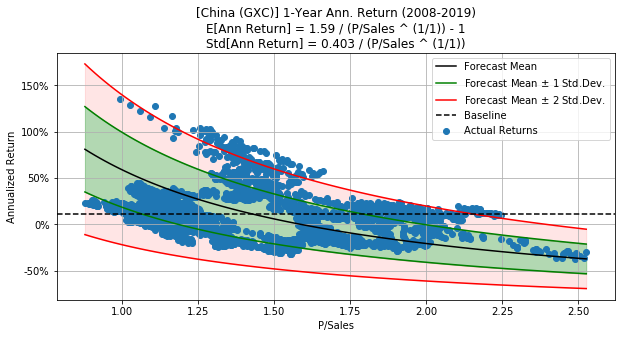

	Forecast	Baseline	p-value
MAE:	26.5%		17.6%		8.90e-164
R^2:	-0.63


In [67]:
plot_ann_returns(years=1, ticker=ticker_name_GXC, df=df_GXC)

### China (GXC) - 2 Year Returns

For 2-year investment periods, the forecasting model still fits the data very poorly with $R^2 = -0.35$.

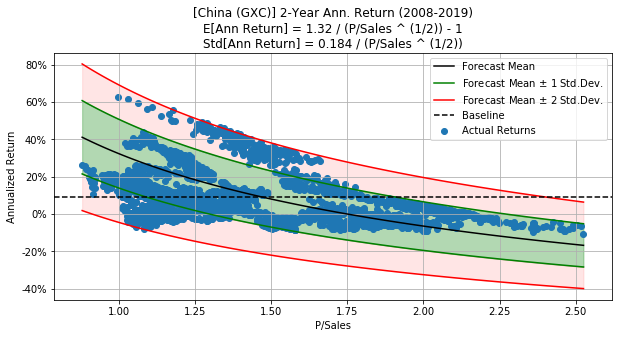

	Forecast	Baseline	p-value
MAE:	12.3%		10.4%		1.26e-25
R^2:	-0.35


In [68]:
plot_ann_returns(years=2, ticker=ticker_name_GXC, df=df_GXC)

### China (GXC) - 5 Year Returns

For 5-year investment periods, the forecasting model still fits the data very poorly with $R^2 = -0.85$.

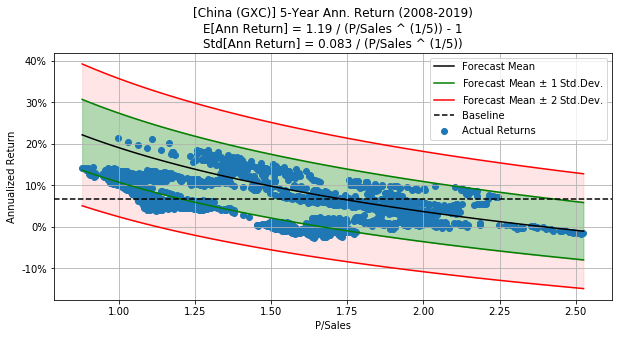

	Forecast	Baseline	p-value
MAE:	5.3%		3.9%		2.13e-44
R^2:	-0.85


In [69]:
plot_ann_returns(years=5, ticker=ticker_name_GXC, df=df_GXC)

### China (GXC) - 10 Year Returns

For 10-year investment periods, the forecasting model fits the historical data reasonably well with $R^2 = 0.66$. However, the data covers the period between 2008 and 2019, which means that the start-dates only range between 2008 and 2009, so it is actually a very short period that is covered, so this should not be considered a reliable result.

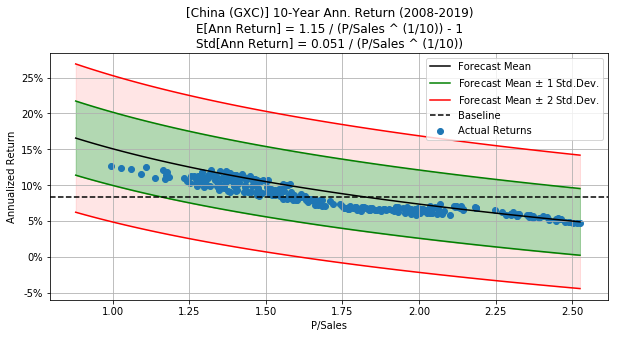

	Forecast	Baseline	p-value
MAE:	1.0%		1.9%		3.65e-24
R^2:	0.66


In [70]:
plot_ann_returns(years=10, ticker=ticker_name_GXC, df=df_GXC)

### China (GXC) - 3 to 7 Year Returns

This plot shows the historical returns averaged for 3-7 year investment periods. There appears to be 2 trends in the data, and because the forecasting model can only estimate a single trend, the overall fit is quite weak with $R^2 = 0.15$.

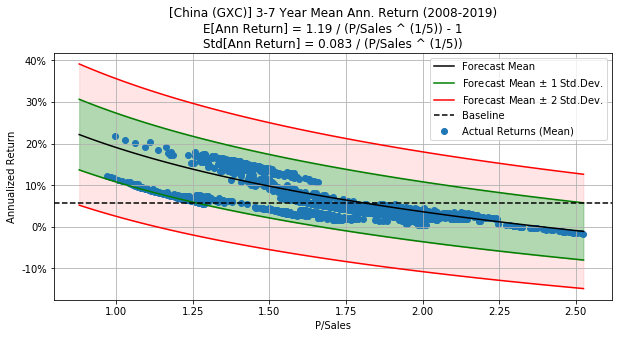

	Forecast	Baseline	p-value
MAE:	3.0%		3.3%		5.76e-03
R^2:	0.15


In [71]:
plot_ann_returns(years=5, years_range=2,
                 ticker=ticker_name_GXC, df=df_GXC)

## Correlation

We will now study the correlation of the P/Sales ratios of the stock indices. This is of interest because it tells us whether the stock indices tend to be cheap or expensive at the same time.

This is important if we want to construct an investment strategy that switches between these stock indices, so that it buys the cheap indices and sells the expensive indices.

We consider all of the above stock indicies, as well as the U.S. stock indices from the 
[previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01E_Forecasting_US_Stock_Indices.ipynb.ipynb).

In [72]:
# Lists of tickers and data we want to compare.
tickers = [ticker_SP500, ticker_SP400, ticker_SP600, ticker_QQQ,
           ticker_VGK, ticker_EWG, ticker_EWO, ticker_EEM,
           ticker_GXC]
dfs = [df_SP500[PSALES], df_SP400[PSALES],
       df_SP600[PSALES], df_QQQ[PSALES],
       df_VGK[PSALES], df_EWG[PSALES],
       df_EWO[PSALES], df_EEM[PSALES],
       df_GXC[PSALES]]

# Create a single DataFrame with all the P/Sales ratios.
df_psales = pd.concat(dfs, axis=1).dropna()

# Rename columns to ticker-symbols.
df_psales.set_axis(tickers, axis=1, inplace=True)

The following table shows the correlation of the P/Sales ratios for the stock indices. A value of 1 means complete positive correlation so that the P/Sales ratios of two indices are always high or low at the same time, a value of 0 means there is no correlation, a value of -1 means complete negative correlation.

The table shows that the stock indices that are generally least correlated with other indices are EEM (Emerging Markets) and GXC (China). Unfortunately, those two had a very poor fit of the forecasting model on the historical data, so the forecasted return is probably unreliable.

The index for European Developed stocks (VGK) was strongly correlated with all the U.S. stock indices and those for Germany (EWG) and Austria (EWO).

Some of the lowest correlations were between Austria (EWO) and the U.S. stock indices especially S&P 500 and 600.

In [73]:
df_psales.corr()

,S&P 500,S&P 400,S&P 600,QQQ,VGK,EWG,EWO,EEM,GXC
S&P 500,1.000000,0.907049,0.863519,0.910407,0.753193,0.876988,0.208567,0.038227,-0.181162
S&P 400,0.907049,1.000000,0.940730,0.897448,0.782276,0.839378,0.340384,0.140392,-0.052685
S&P 600,0.863519,0.940730,1.000000,0.798109,0.686519,0.772652,0.208015,-0.014119,-0.218964
QQQ,0.910407,0.897448,0.798109,1.000000,0.879046,0.915301,0.496005,0.363271,0.168032
VGK,0.753193,0.782276,0.686519,0.879046,1.000000,0.924570,0.731600,0.578823,0.375217
EWG,0.876988,0.839378,0.772652,0.915301,0.924570,1.000000,0.543229,0.398444,0.159478
EWO,0.208567,0.340384,0.208015,0.496005,0.731600,0.543229,1.000000,0.917571,0.805761
EEM,0.038227,0.140392,-0.014119,0.363271,0.578823,0.398444,0.917571,1.000000,0.903415
GXC,-0.181162,-0.052685,-0.218964,0.168032,0.375217,0.159478,0.805761,0.903415,1.000000


We can also make a scatter-plot of the P/Sales ratios for the S&P 500 (U.S. Large-Cap) versus EWO (Austria). This has a correlation coefficient of 0.21, but the plot shows that it is actually highly correlated in two trend-lines. These are perhaps for different periods of time.

Note that this also shows one of the weaknesses of the correlation coefficient, that it is a kind of summary statistic that can be fooled by odd data.

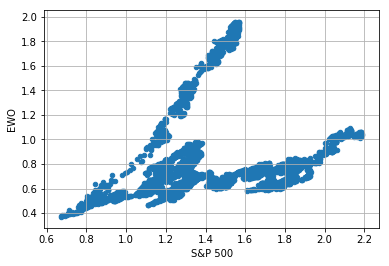

In [74]:
df_psales.plot(kind='scatter', x=ticker_SP500, y=ticker_EWO, grid=True)

We see a similar tendency in the scatter-plot for the P/Sales ratios of EWG (Germany) versus EWO (Austria).

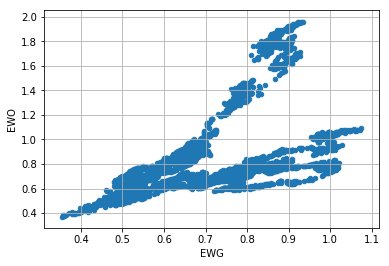

In [75]:
df_psales.plot(kind='scatter', x=ticker_EWG, y=ticker_EWO, grid=True)

## Excel Spreadsheet

The above statistics and forecasting formulas have been summarized in an [Excel Spreadsheet](https://github.com/Hvass-Labs/FinanceOps/raw/master/Forecasting_Stock_Indices.xlsx) which makes it easy to enter new P/Sales ratios and compare the forecasted returns for both U.S. and international stock indices.

## Conclusion

This paper applied our method for long-term stock forecasting from a [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) to five international stock indices.

The forecasting model had a good fit on historical returns for the broad Developed Europe index (tracked by the ETF with ticker symbol VGK) and for indices for the individual countries Germany (EWG) and Austria (EWO).

But the forecasting model had a poor fit on historical returns for the broad Emerging Markets index (EEM) and China index (GXC), possibly because the historical P/Sales and sales growth seemed to have distinctly different phases for those indices.

Whether the forecasting model will work in the future, depends on how accurately we can estimate the future averages for the dividend yield, sales growth and P/Sales ratios for a stock index.

## Research Ideas

You are strongly encouraged to do more research on this topic. If you make any new discoveries then please let me know your results. 

To my knowledge, there are no academic studies of predicting the long-term returns of stocks and stock-markets as we have done here. A lot more research can be done on this subject and it may impact many areas of both theoretical and applied finance.

Here are a few more research ideas to get you started:

- Scrutinize the mathematics and Python implementation to try and find errors.

- If you have access to financial data for other indices, try and use it with the forecasting model. Does it work? Why not?

- Why does the forecasting model have a poor fit on historical returns for EEM (Emerging Markets) and GXC (China)?

- What is the effect of currency conversion rates on the forecasting model?

- Can you find a better way of estimating the future mean dividend yield, sales growth, and P/Sales ratios?

- How is the P/Sales ratio determined for different stocks and indices? Is it related to the profit margin and sales growth?

- If you had more stock indices with low correlation, how would you do portfolio optimization?

## License (MIT)

Copyright (c) 2018-2019 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.